In [20]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Task A: binary classification task (using PneumoniaMNIST dataset)

In [21]:
import A
from A import info, dataset, evaluator, pytorchtools, LeNet5

In [22]:
data_flag = 'pneumoniamnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001

info = A.info.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = dataset.PneumoniaMNIST

In [23]:
# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform)
val_dataset = DataClass(split='val', transform=data_transform)
test_dataset = DataClass(split='test', transform=data_transform)
pil_dataset = DataClass(split='train')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

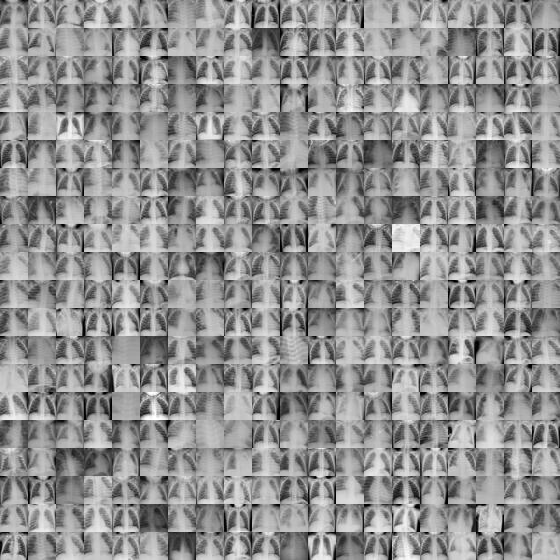

In [24]:
train_dataset.montage(length=20)

In [25]:
model = LeNet5.LeNet5(in_channels=n_channels, num_classes=n_classes)
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [26]:
def model_train():

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 

    # initialize the early_stopping object
    early_stopping = A.pytorchtools.EarlyStopping(patience=5, verbose=True)

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        test_correct = 0
        test_total = 0
        
        model.train()
        for inputs, targets in tqdm(train_loader):
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for inputs, targets in tqdm(valid_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                
            # calculate the loss
            loss = criterion(outputs, targets)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(NUM_EPOCHS))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{NUM_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    torch.save(model, './A/whole_model.pth')
    return avg_train_losses, avg_valid_losses
train_loss, valid_loss = model_train()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.65it/s]


[ 0/20] train_loss: 0.60426 valid_loss: 0.57288
Validation loss decreased (inf --> 0.572876).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.75it/s]


[ 1/20] train_loss: 0.51074 valid_loss: 0.45547
Validation loss decreased (0.572876 --> 0.455474).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.55it/s]


[ 2/20] train_loss: 0.39886 valid_loss: 0.32469
Validation loss decreased (0.455474 --> 0.324686).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.83it/s]


[ 3/20] train_loss: 0.28549 valid_loss: 0.23650
Validation loss decreased (0.324686 --> 0.236504).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.83it/s]


[ 4/20] train_loss: 0.21597 valid_loss: 0.20481
Validation loss decreased (0.236504 --> 0.204810).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.32it/s]


[ 5/20] train_loss: 0.18280 valid_loss: 0.15886
Validation loss decreased (0.204810 --> 0.158865).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.33it/s]


[ 6/20] train_loss: 0.16393 valid_loss: 0.13350
Validation loss decreased (0.158865 --> 0.133497).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.52it/s]


[ 7/20] train_loss: 0.14967 valid_loss: 0.12974
Validation loss decreased (0.133497 --> 0.129745).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.66it/s]


[ 8/20] train_loss: 0.13843 valid_loss: 0.13490
EarlyStopping counter: 1 out of 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


[ 9/20] train_loss: 0.13026 valid_loss: 0.12440
Validation loss decreased (0.129745 --> 0.124402).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.98it/s]


[10/20] train_loss: 0.12108 valid_loss: 0.10475
Validation loss decreased (0.124402 --> 0.104751).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.24it/s]


[11/20] train_loss: 0.11539 valid_loss: 0.08547
Validation loss decreased (0.104751 --> 0.085472).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.31it/s]


[12/20] train_loss: 0.10789 valid_loss: 0.08973
EarlyStopping counter: 1 out of 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.64it/s]


[13/20] train_loss: 0.10281 valid_loss: 0.09003
EarlyStopping counter: 2 out of 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.48it/s]


[14/20] train_loss: 0.09943 valid_loss: 0.09467
EarlyStopping counter: 3 out of 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.43it/s]


[15/20] train_loss: 0.09379 valid_loss: 0.10378
EarlyStopping counter: 4 out of 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.52it/s]

[16/20] train_loss: 0.09164 valid_loss: 0.11410
EarlyStopping counter: 5 out of 5
Early stopping


In [27]:
A.evaluator.Evaluator

A.evaluator.Evaluator

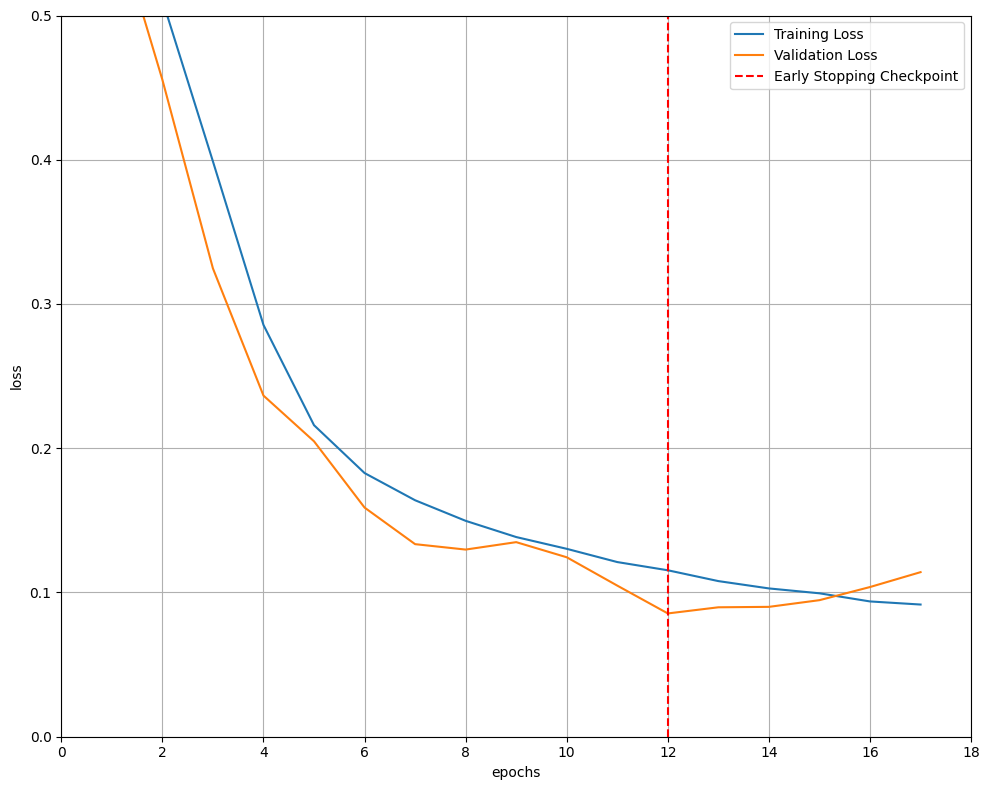

In [31]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('./A/loss_plot.png', bbox_inches='tight')

In [32]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = A.evaluator.Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.994  acc:0.956
test  auc: 0.943  acc:0.881


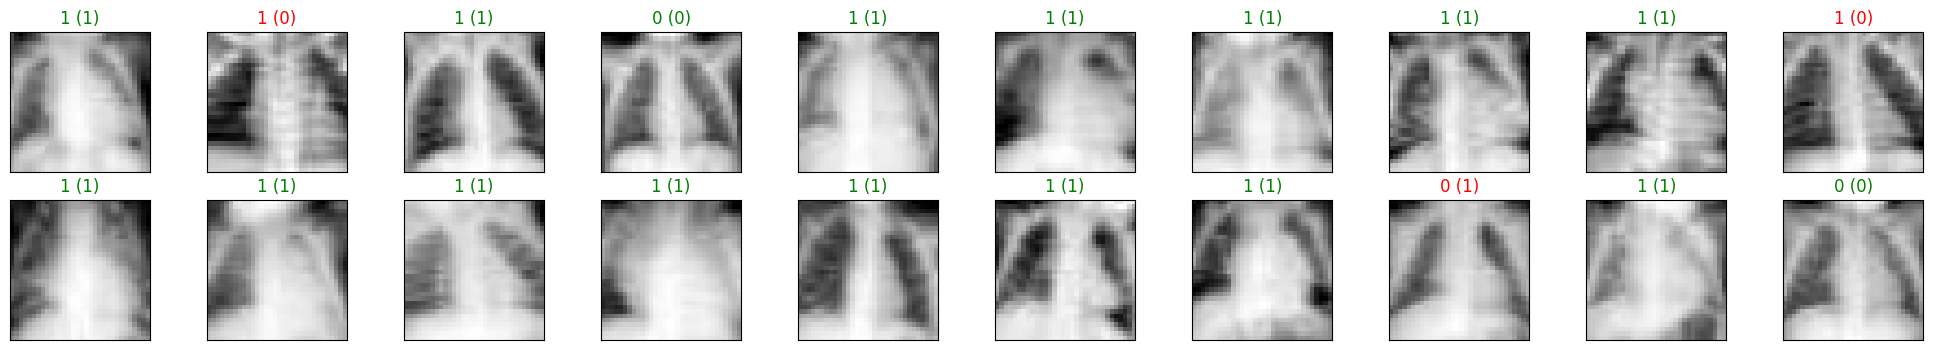

In [33]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Task B: multi-class classification task (using PathMNIST dataset)

In [11]:
import B,os,random
from B import info, dataset, evaluator, pytorchtools, LeNet5, LeNet5_optim
# from torchvision import models

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)


In [12]:
data_flag = 'pathmnist'

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 0.001

info = B.info.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = dataset.PathMNIST

In [13]:
# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform)
val_dataset = DataClass(split='val', transform=data_transform)
test_dataset = DataClass(split='test', transform=data_transform)
pil_dataset = DataClass(split='train')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [14]:
data = np.load('./Datasets/pathmnist.npz')
images = data['train_images']
image_shape = images.shape[1:]
print("Image shape:", image_shape)

Image shape: (28, 28, 3)


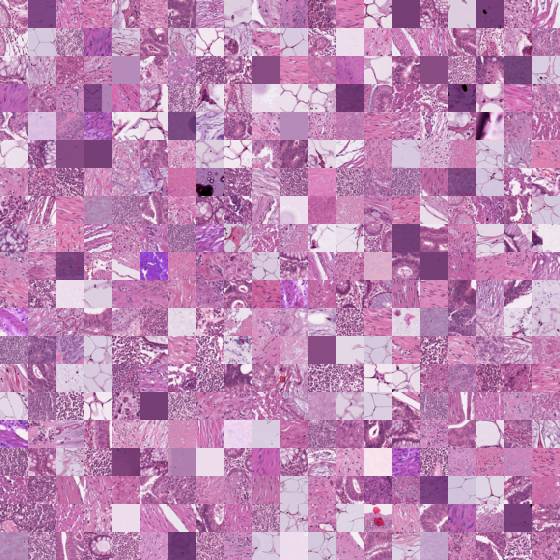

In [15]:
train_dataset.montage(length=20)

In [16]:
model = LeNet5.LeNet5(in_channels=n_channels, num_classes=n_classes)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
model = LeNet5_optim.LeNet5_optim(in_channels=n_channels, num_classes=n_classes)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def model_train():

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 

    # initialize the early_stopping object
    early_stopping = B.pytorchtools.EarlyStopping(patience=5, verbose=True)

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        test_correct = 0
        test_total = 0
        
        model.train()
        for inputs, targets in tqdm(train_loader):
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for inputs, targets in tqdm(valid_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                
            # calculate the loss
            loss = criterion(outputs, targets)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(NUM_EPOCHS))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{NUM_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    torch.save(model, './B/whole_model_basis_2.pth')
    return avg_train_losses, avg_valid_losses
train_loss, valid_loss = model_train()

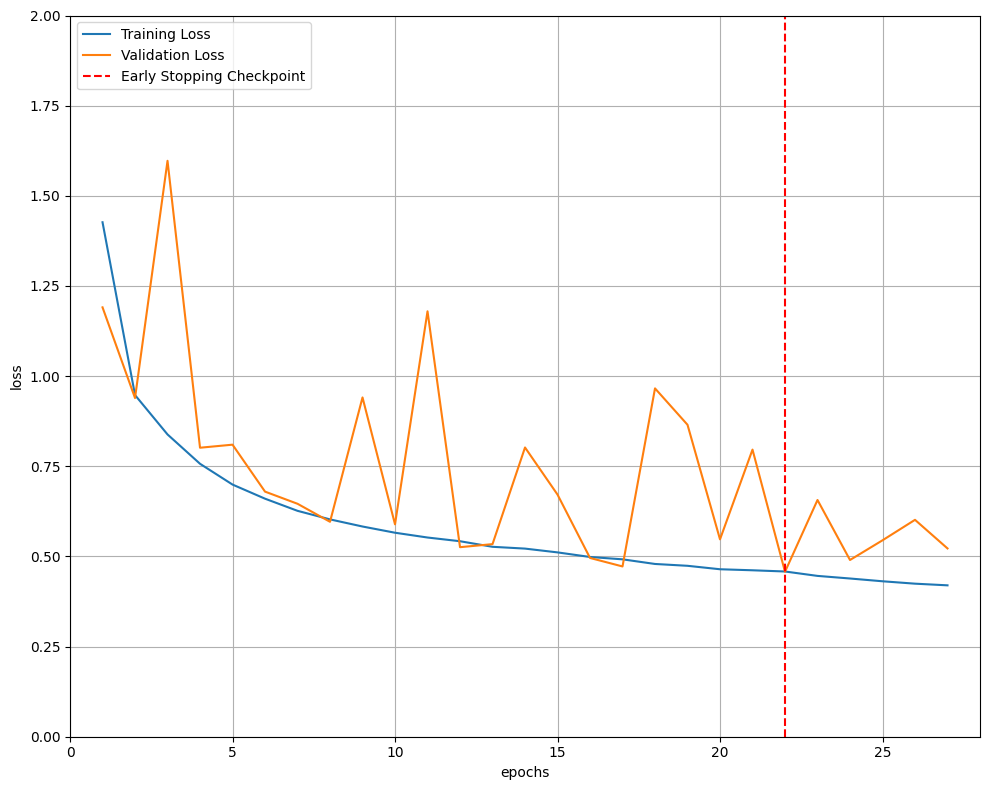

In [267]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('./B/loss_plot_basis_2.png', bbox_inches='tight')

In [268]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = B.evaluator.Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        print("y_score number of samples:", y_score.shape[0])
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
y_score 样本数: 89996
train  auc: 0.982  acc:0.824
y_score 样本数: 7180
test  auc: 0.949  acc:0.732


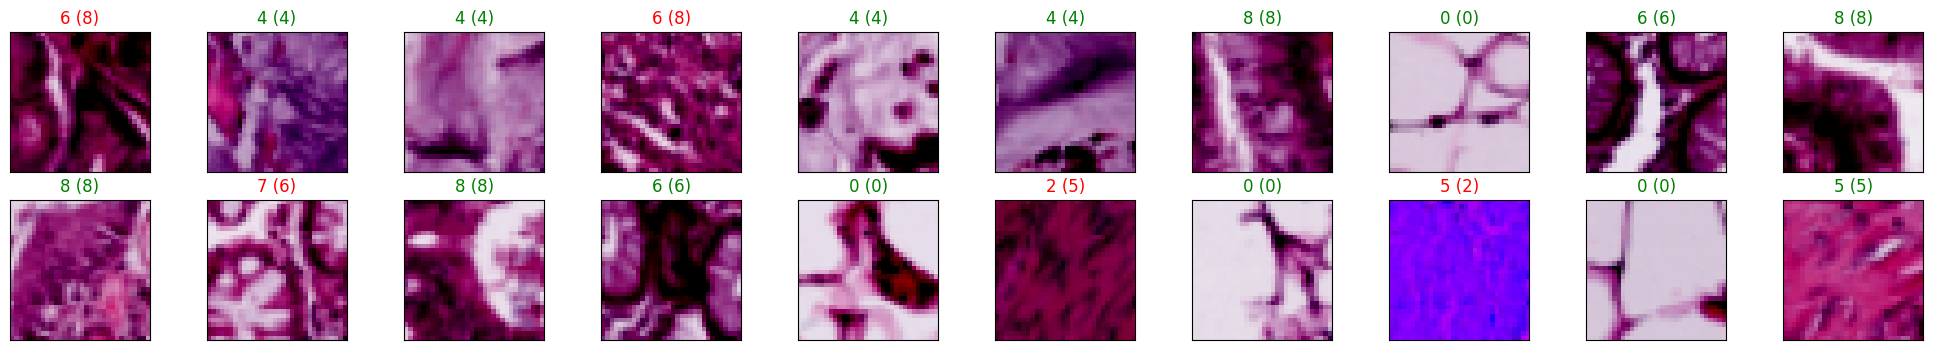

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze((images[idx].transpose((1, 2, 0))* 255).clip(0, 255).astype(np.uint8)))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))
